In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from vnstock import Vnstock
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [116]:
df = Vnstock().stock(symbol='VPB', source='VCI').quote.history(
            start="2020-05-30",
            end="2025-05-30",
            interval="1D"
        )
df.shape
# df = df.set_index('time')

(1249, 6)

### Tạo hàm

In [11]:
df

,time,open,high,low,close,volume
0,2020-06-01,7.75,8.01,7.64,8.01,8948760
1,2020-06-02,8.11,8.11,7.82,7.87,5977010
2,2020-06-03,7.88,7.96,7.82,7.93,3922100
3,2020-06-04,8.00,8.03,7.82,7.83,5967540
4,2020-06-05,7.80,8.00,7.77,8.00,5507250
...,...,...,...,...,...,...
1244,2025-05-26,18.10,18.20,17.30,18.15,24591056
1245,2025-05-27,18.15,18.30,18.05,18.10,22992680
1246,2025-05-28,18.20,18.30,18.00,18.00,13063100
1247,2025-05-29,18.10,18.55,18.00,18.15,46408000


In [4]:
def cal_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"R2: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

def cal_metrics_1by1(y_true, y_pred, df_all):
    y_true = np.ravel(y_true) 
    y_pred = np.ravel(y_pred)

    rmse = np.sqrt((y_true - y_pred) ** 2)
    mae = np.abs(y_true - y_pred)
    mape = np.abs((y_true - y_pred) / y_true)

    met = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }, index  = df_all[-len(y_true):].time)
    return met.round(4)

def plot_resi(df_metrics):
    df_metrics['phan_du'] = df_metrics['y_pred'] - df_metrics['y_true']
    mean_residual = df_metrics['phan_du'].mean()
    # Thiết lập biểu đồ
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    # Vẽ histogram bằng Seaborn để có đường cong KDE
    sns.histplot(data=df_metrics, x='phan_du', kde=True, ax=ax, bins=30)
    # Vẽ các đường tham chiếu quan trọng
    ax.axvline(mean_residual, color='green', linestyle=':', linewidth=2, label=f'Phần dư trung bình = {mean_residual:.2f}')

    ax.set_title('Biểu đồ Histogram của Phần dư', fontsize=16)
    ax.set_xlabel('Phần dư (Residuals)')
    ax.set_ylabel('Tần suất')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()

def plot_metrics(df_metrics, metric):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(df_metrics.index, df_metrics[metric], color='green', label='Sai số tuyệt đối hàng ngày')
    mean_error = df_metrics[metric].mean()
    ax.axhline(mean_error, color='red', linestyle='--', label=f'Sai số trung bình = {mean_error:.2f}')
    ax.set_title(f'Biểu đồ Sai số Tuyệt đối {metric} theo Thời gian', fontsize=14)
    ax.set_xlabel('Ngày (Index)')
    ax.set_ylabel('Giá trị Sai số')
    ax.legend()

def adf_test(timeseries):
    print(">>> Kiểm tra ADF <<<")
    result = adfuller(timeseries.dropna(), autolag='AIC')  # Loại bỏ giá trị NaN nếu có
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    if result[1] <= 0.05:
        print("Kết luận: CHUỖI DỪNG (reject H0)")
    else:
        print("Kết luận: CHUỖI KHÔNG DỪNG (fail to reject H0)")

def time_features(df, time_col):
    df['day_of_week'] = df[time_col].dt.dayofweek           # Thứ trong tuần (0=Thứ 2)
    # df['is_thursday'] = (df[time_col].dt.dayofweek == 3).astype(int)
    df['is_third_friday'] = ((df[time_col].dt.dayofweek == 4) & 
                           ((df[time_col].dt.day - 1) // 7 + 1 == 3)).astype(int)
    df['month'] = df[time_col].dt.month                     # Tháng
    df['year'] = df[time_col].dt.year                       # Năm
    df['day'] = df[time_col].dt.day                         # Ngày trong tháng
    return df

# DỰ BÁO DÀI HẠN

## ARIMA

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [ ]:
adf_test(df['close'])

In [ ]:
split_point = int(len(df) * 0.85)
train = df.iloc[:split_point]
test = df.iloc[split_point:]

# Bước 1: Sử dụng Auto ARIMA để tìm tham số tối ưu
auto_model = auto_arima(
    train['close'],  # Chuỗi thời gian
    seasonal=False,  # Tắt yếu tố mùa vụ (nếu có, dùng seasonal=True)
    trace=False,      # Hiển thị quá trình tìm kiếm
    suppress_warnings=True,
    stepwise=True,   # Tối ưu tốc độ tìm kiếm
    information_criterion='aic'
)

print("Best ARIMA Order:", auto_model.order)
print("Best AIC:", auto_model.aic())

# Bước 2: Huấn luyện mô hình với tham số tối ưu
model = ARIMA(train['close'], order=auto_model.order).fit()
forecast_arm = model.forecast(len(test))

In [ ]:
cal_metrics(test['close'], forecast_arm)

In [ ]:
# Biểu đồ so sánh thực tế và dự đoán trên tập test
plt.figure(figsize=(12,6))
plt.plot(train['time'], train['close'], label='Train', color='blue')
plt.plot(test['time'], test['close'], label='Test', color='green')
plt.plot(test['time'], forecast_arm, label='Forecast', color='red')
plt.title('So sánh giá thực tế và dự báo')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [ ]:
df_arx = df.drop(['open','high', 'low', 'volume'], axis=1)
df_arx = time_features(df_arx, 'time')

split_point = int(len(df) * 0.85)
train = df_arx.iloc[:split_point]
test = df_arx.iloc[split_point:]

# Chuỗi chính
y_train = train['close']
y_test = test['close']

X_train = train[['day_of_week', 'is_third_friday', 'month', 'year', 'day']]
X_test = test[['day_of_week', 'is_third_friday', 'month', 'year', 'day']]
# X_train = None
# X_test = None

stepwise_model = auto_arima(
    y=y_train,
    exogenous=X_train,
    start_p=0, start_q=0,
    max_p=10, max_q=10,
    d=None,         
    seasonal=False,     
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("Tham số ARIMA tốt nhất:", stepwise_model.order)

# Khởi tạo mô hình SARIMAX với tham số tìm được
model = SARIMAX(
    y_train,
    exog=X_train,
    order=stepwise_model.order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit()

# Dự báo
n_test = len(y_test)
forecast_arx = model_fit.predict(start=len(y_train), end=len(y_train) + n_test - 1, exog=X_test)


cal_metrics(y_test, forecast_arx)

In [ ]:
# Biểu đồ so sánh thực tế và dự đoán trên tập test
plt.figure(figsize=(12,6))
# plt.plot(train['time'], train['close'], label='Train', color='blue')
plt.plot(y_test, label='Test', color='green')
plt.plot(forecast_arx, label='Forecast', color='red')
plt.title('So sánh giá thực tế và dự báo')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Prophet

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

In [ ]:
df_pp = df.drop(['open','high', 'low', 'volume'], axis=1)
# df.set_index('time', inplace=True)

df_pp = time_features(df_pp, 'time')

# Time series features
split_point = int(len(df_pp) * 0.85)
train = df_pp.iloc[:split_point].copy()
test = df_pp.iloc[split_point:].copy()

train_prophet = train.rename(columns={'time':'ds', 'close': 'y'}) # 1000 dòng
test_prophet = test.rename(columns={'time':'ds', 'close': 'y'}) # 250 dòng

df_pp.head()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Grid search tham số
def grid_search_prophet_with_regressors(train_data, test_data):
    param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0, 100.0]
    }
    
    best_params = None
    best_score = float('inf')
    
    print("Đang tìm tham số tối ưu...")
    
    for cp_scale in param_grid['changepoint_prior_scale']:
        for s_scale in param_grid['seasonality_prior_scale']:
            try:
                # Tạo model với tham số
                model = Prophet(
                    changepoint_prior_scale=cp_scale,
                    weekly_seasonality=True,
                    seasonality_prior_scale=s_scale,
                    seasonality_mode='additive'
                )
                
                # Thêm các regressor
                model.add_regressor('day_of_week')
                model.add_regressor('month')
                model.add_regressor('year')
                model.add_regressor('is_third_friday')
                model.add_regressor('day')
                
                # Chia train thành train_subset và val_subset để validation
                split_point = int(len(train_data) * 0.8)
                train_subset = train_data.iloc[:split_point]
                val_subset = train_data.iloc[split_point:]
                
                # Fit model với train_subset
                model.fit(train_subset)
                
                # Tạo future cho validation
                future_val = pd.DataFrame({'ds': pd.concat([train_subset['ds'], val_subset['ds']]).reset_index(drop=True)})
                future_val = time_features(future_val, 'ds')
                
                # Predict
                forecast_val = model.predict(future_val)
                
                # Tính MAE cho phần validation (cuối cùng)
                y_true = val_subset['y'].values
                y_pred = forecast_val['yhat'].iloc[-len(val_subset):].values
                mae = mean_absolute_error(y_true, y_pred)
                
                # print(f"cp_scale={cp_scale}, s_scale={s_scale}, MAE={mae:.4f}")
                
                if mae < best_score:
                    best_score = mae
                    best_params = {
                        'changepoint_prior_scale': cp_scale,
                        'seasonality_prior_scale': s_scale
                    }
                    
            except Exception as e:
                print(f"Lỗi với cp_scale={cp_scale}, s_scale={s_scale}: {e}")
                continue
    
    return best_params, best_score

# Tìm tham số tối ưu
best_params, best_score = grid_search_prophet_with_regressors(train_prophet, test_prophet)

print(f"\nTham số tối ưu:")
print(f"changepoint_prior_scale: {best_params['changepoint_prior_scale']}")
print(f"seasonality_prior_scale: {best_params['seasonality_prior_scale']}")
print(f"MAE validation: {best_score:.4f}")

# Tạo model cuối cùng với tham số tối ưu
model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    weekly_seasonality=True,
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode='additive'
)

# Thêm các regressor
model.add_regressor('day_of_week')
model.add_regressor('month')
model.add_regressor('year')
model.add_regressor('is_third_friday')
model.add_regressor('day')

# Fit với toàn bộ tập train
model.fit(train_prophet)


future = pd.DataFrame({'ds': pd.concat([train_prophet['ds'], test_prophet['ds']]).reset_index(drop=True)})
future = time_features(future, 'ds')

# Dự đoán
forecast = model.predict(future)

# Lấy kết quả dự đoán cho tập test
test_predictions = forecast['yhat'].iloc[-len(test_prophet):].values

print(f"\nDự đoán hoàn thành!")
print(f"Số lượng dự đoán: {len(test_predictions)}")

# Lưu kết quả
test_results = pd.DataFrame({
    'ds': test_prophet['ds'],
    'y_true': test_prophet['y'] if 'y' in test_prophet.columns else None,
    'y_pred': test_predictions
})

cal_metrics(test_results.y_true, test_results.y_pred)

In [ ]:
f, ax = plt.subplots(figsize=(15,7))
ax.scatter(test_prophet['ds'], test_prophet['y'], color='r', s=5)
fig = model.plot(forecast, ax=ax)

In [ ]:
model = Prophet(
    changepoint_prior_scale=0.2,   # MẶC ĐỊNH: 0.05. Tăng để xu hướng linh hoạt hơn.
    weekly_seasonality=True,
    seasonality_prior_scale=5,  # MẶC ĐỊNH: 10.0. Giữ nguyên hoặc tăng/giảm nếu cần.
    # holidays_prior_scale=10.0,     # MẶC ĐỊNH: 10.0. Chỉ có tác dụng nếu bạn thêm ngày lễ.
    seasonality_mode='additive'    # MẶC ĐỊNH: 'additive'. Thử 'multiplicative' nếu biến động tăng/giảm theo xu hướng.
)

model.add_regressor('day_of_week')
model.add_regressor('month')
model.add_regressor('year')
model.add_regressor('is_third_friday')
model.add_regressor('day')

model.fit(train_prophet)

future = pd.DataFrame({'ds': pd.concat([train_prophet['ds'], test_prophet['ds']]).reset_index(drop=True)})
future = time_features(future, 'ds')

forecast = model.predict(future)

In [ ]:
cal_metrics(test_prophet['y'], forecast['yhat'].iloc[-len(test_prophet):])

# DỰ BÁO NGẮN HẠN

## LSTM

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, BatchNormalization

2025-06-14 01:00:29.609826: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [101]:
features = ['close', 'high', 'low', 'volume']
data = df[features].values
# ----------------------------------------------------

training_data_len = int(np.ceil(len(data) * 0.8))

# Chuẩn hoá dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
scaled_data = sc.fit_transform(data)

# Tách dữ liệu đã được chuẩn hoá
train_data = scaled_data[0:int(training_data_len), :]

# HÀM TẠO DỮ LIỆU DẠNG CHUỖI THỜI GIAN
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(time_step, len(dataset)):
        # Lấy tất cả các feature cho dataX
        dataX.append(dataset[i-time_step:i, :]) # Dùng dấu ':' để lấy tất cả 4 cột
        # Chỉ lấy giá 'close' (cột đầu tiên, index 0) cho dataY
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)
# ---------------------------------------------------

# Đặt độ dài cửa sổ thời gian
time_step = 60
x_train, y_train = create_dataset(train_data, time_step)


# <<< THAY ĐỔI 3: CẬP NHẬT RESHAPE DỮ LIỆU >>>
# Reshape dữ liệu đầu vào cho LSTM [samples, time steps, features]
# Số feature giờ là len(features) (tức là 4), không còn là 1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))
# -------------------------------------------------


# --- 2. XÂY DỰNG VÀ HUẤN LUYỆN MÔ HÌNH ---

model = Sequential()
# <<< THAY ĐỔI 4: CẬP NHẬT INPUT_SHAPE CỦA LSTM >>>
# Cập nhật chiều cuối cùng của input_shape thành len(features)
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], len(features))))
# -------------------------------------------------
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1)) # Đầu ra vẫn là 1 giá trị (giá close)
model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks vẫn giữ nguyên
save_model_path = 'best_multivariate_model.keras'
best_model = ModelCheckpoint(save_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Huấn luyện mô hình (không cần thay đổi)
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[best_model, early_stop],
                    shuffle=True,
                    verbose=1)


# --- 3. DỰ ĐOÁN VÀ ĐÁNH GIÁ TRÊN TẬP TEST ---

# Tải mô hình tốt nhất đã lưu
final_model = load_model(save_model_path)

# Chuẩn bị dữ liệu test (không cần thay đổi)
test_data = scaled_data[training_data_len - time_step:, :]
x_test, y_test_actual = create_dataset(test_data, time_step)

# Reshape dữ liệu test (giống như với x_train)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

# Dự đoán
y_test_predict = final_model.predict(x_test)


# <<< THAY ĐỔI 5: SỬA LẠI CÁCH INVERSE_TRANSFORM (RẤT QUAN TRỌNG) >>>
# 1. Tạo một mảng rỗng có shape (số_lượng_dự_đoán, 4)
predict_extended = np.zeros((len(y_test_predict), len(features)))
# 2. Đặt cột đầu tiên (cột 'close') của mảng này bằng giá trị dự đoán của chúng ta
predict_extended[:, 0] = y_test_predict.flatten()
# 3. Bây giờ mới inverse_transform
y_test_predict = sc.inverse_transform(predict_extended)[:, 0] # Chỉ lấy cột đầu tiên sau khi inverse

# Đối với giá trị thực tế (y_test_actual)
actual_extended = np.zeros((len(y_test_actual), len(features)))
actual_extended[:, 0] = y_test_actual.flatten()
y_test_actual = sc.inverse_transform(actual_extended)[:, 0]
# -------------------------------------------------------------------


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0833
Epoch 1: val_loss improved from inf to 0.00210, saving model to best_multivariate_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - loss: 0.0804 - val_loss: 0.0021
Epoch 2/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0105
Epoch 2: val_loss did not improve from 0.00210
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0105 - val_loss: 0.0032
Epoch 3/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0100
Epoch 3: val_loss improved from 0.00210 to 0.00095, saving model to best_multivariate_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0098 - val_loss: 9.4507e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0073
Epoch 4: val_loss did not improve from 0.00095
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0073 - val_loss: 0.0028
Epoch 5/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0062
Epoch 5: val_loss did not improve from 0.00095
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 7

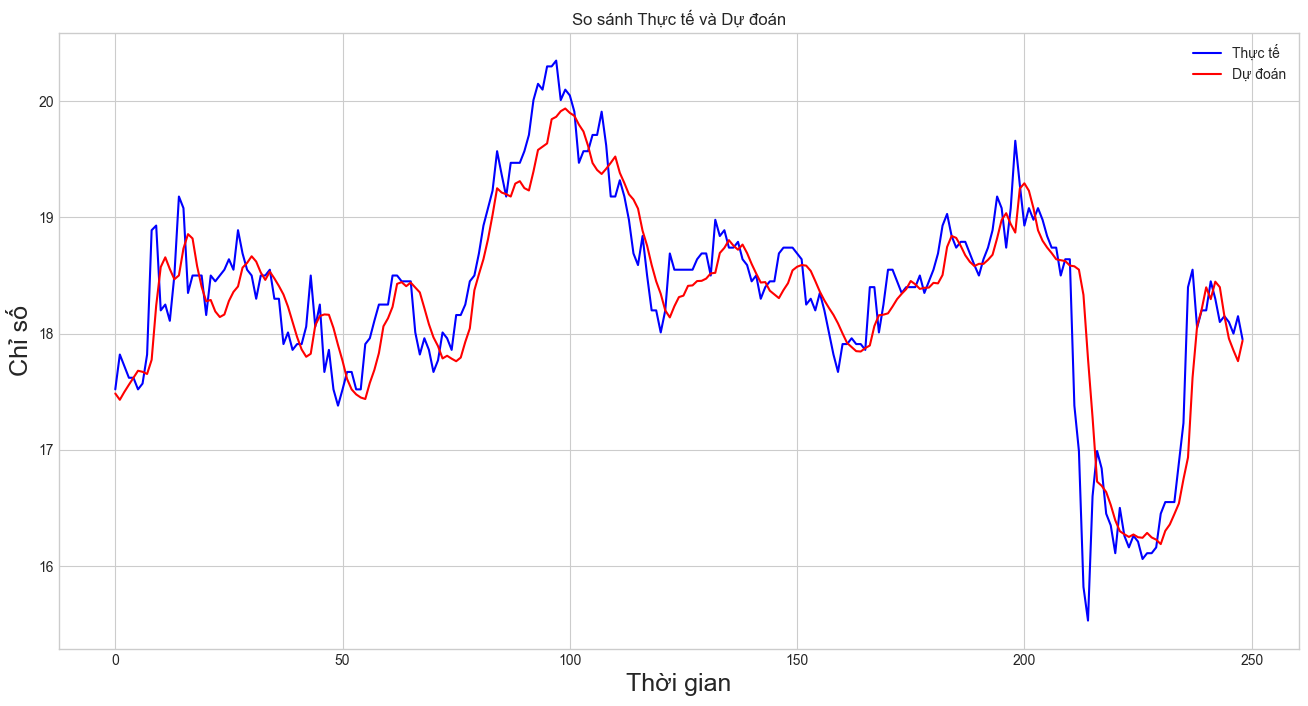

In [102]:
# Tối ưu: Trực quan hoá kết quả
plt.figure(figsize=(16, 8))
plt.title('So sánh Thực tế và Dự đoán')
plt.xlabel('Thời gian', fontsize=18)
plt.ylabel('Chỉ số', fontsize=18)
plt.plot(y_test_actual, color='blue', label='Thực tế')
plt.plot(y_test_predict, color='red', label='Dự đoán')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
metrics = cal_metrics_1by1(y_test_actual, y_test_predict, df)
metrics.tail(10)

,y_true,y_pred,RMSE,MAE,MAPE
time,,,,,
2025-05-19,18.20,18.2069,0.0069,0.0069,0.0004
2025-05-20,18.20,18.3985,0.1985,0.1985,0.0109
2025-05-21,18.45,18.2966,0.1534,0.1534,0.0083
2025-05-22,18.30,18.4470,0.1470,0.1470,0.0080
2025-05-23,18.10,18.4000,0.3000,0.3000,0.0166
2025-05-26,18.15,18.1524,0.0024,0.0024,0.0001
2025-05-27,18.10,17.9572,0.1428,0.1428,0.0079
2025-05-28,18.00,17.8559,0.1441,0.1441,0.0080
2025-05-29,18.15,17.7630,0.3870,0.3870,0.0213


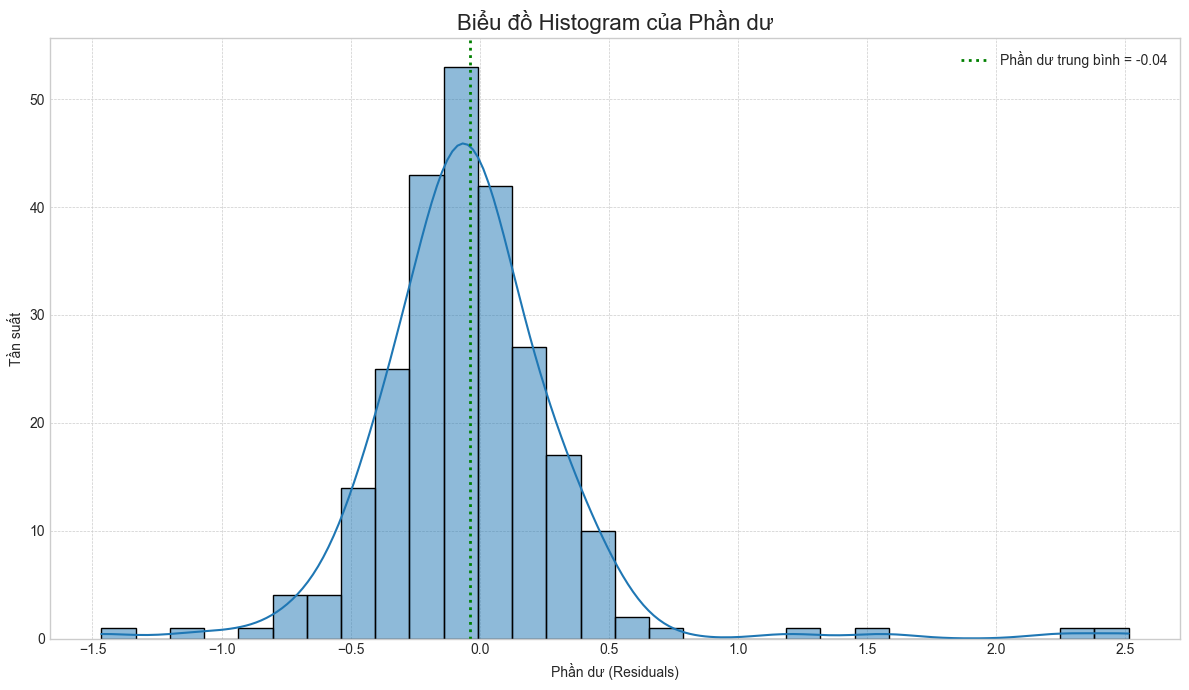

In [104]:
plot_resi(metrics)

In [105]:
cal_metrics(y_test_actual, y_test_predict)

R2: 0.8013
RMSE: 0.3865
MAE: 0.2512
MAPE: 0.0138


## GRU

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, BatchNormalization

2025-06-13 09:09:17.306231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [117]:
TARGET_COLUMN = 'close'
FEATURE_COLUMNS = ['close', 'high', 'low', 'volume'] 
LOOK_BACK = 50
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1

# Chỉ lấy các cột đặc trưng cần thiết.
data = df[FEATURE_COLUMNS].values


total_len = len(data)
train_split_index = int(total_len * TRAIN_RATIO)
val_split_index = int(total_len * (TRAIN_RATIO + VAL_RATIO))

train_data = data[:train_split_index]
val_data = data[train_split_index:val_split_index]
test_data = data[val_split_index:]
actual_data = df['close'].iloc[val_split_index:].values

print(f"Tập Train: {len(train_data)} mẫu (~{TRAIN_RATIO*100}%)")
print(f"Tập Validation: {len(val_data)} mẫu (~{VAL_RATIO*100}%)")
print(f"Tập Test: {len(test_data)} mẫu (~{100 - (TRAIN_RATIO+VAL_RATIO)*100}%)")

Tập Train: 874 mẫu (~70.0%)
Tập Validation: 125 mẫu (~10.0%)
Tập Test: 250 mẫu (~20.0%)


In [118]:
# --- Bước 2: Chuẩn Hóa Dữ Liệu (Scaling) (Không thay đổi) ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_val_data = scaler.transform(val_data)
scaled_test_data = scaler.transform(test_data)

# --- Bước 3: Tạo Dữ Liệu Chuỗi Thời Gian (Sequences) (Không thay đổi) ---
def create_sequences(input_data, look_back):
    X, y = [], []
    # Dòng này tự động tìm index của 'Close' trong list FEATURE_COLUMNS mới
    target_idx = FEATURE_COLUMNS.index(TARGET_COLUMN)
    for i in range(look_back, len(input_data)):
        X.append(input_data[i-look_back:i, :])
        y.append(input_data[i, target_idx])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train_data, LOOK_BACK)
val_inputs = np.concatenate((scaled_train_data[-LOOK_BACK:], scaled_val_data), axis=0)
X_val, y_val = create_sequences(val_inputs, LOOK_BACK)
test_inputs = np.concatenate((scaled_val_data[-LOOK_BACK:], scaled_test_data), axis=0)
X_test, y_test = create_sequences(test_inputs, LOOK_BACK)

print(f"\nHình dạng của X_train: {X_train.shape}")
print(f"Hình dạng của X_test: {X_test.shape}") 

# --- Bước 4: Cải Tiến Kiến Trúc Mô Hình GRU (Không thay đổi) ---
NUM_FEATURES = len(FEATURE_COLUMNS) 

model = Sequential()
model.add(GRU(units=100, return_sequences=True, input_shape=(LOOK_BACK, NUM_FEATURES)))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# --- Bước 5: Huấn Luyện Mô Hình với Callbacks (Không thay đổi) ---
checkpoint_path = 'best_gru_model_4_features.h5' # Đổi tên file để tránh ghi đè
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

print("\nBắt đầu huấn luyện mô hình...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint, early_stopping],
    shuffle=True,
    verbose=1
)

# --- Bước 6: Đánh Giá Mô Hình (Không thay đổi) ---
best_model = load_model(checkpoint_path)

# 6.2. Dự báo trên tập test
predicted_scaled = best_model.predict(X_test)

# 6.3. Biến đổi ngược (Inverse Transform)
dummy_array = np.zeros((len(predicted_scaled), NUM_FEATURES))
target_idx = FEATURE_COLUMNS.index(TARGET_COLUMN)
dummy_array[:, target_idx] = predicted_scaled.flatten()
forecast = scaler.inverse_transform(dummy_array)[:, target_idx]


Hình dạng của X_train: (824, 50, 4)
Hình dạng của X_test: (250, 50, 4)

Bắt đầu huấn luyện mô hình...
Epoch 1/100


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4395

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 0.4330 - val_loss: 0.0135
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1015 - val_loss: 0.0346
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0777 - val_loss: 0.0222
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0578 - val_loss: 0.0150
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0535 - val_loss: 0.0292
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0389 - val_loss: 0.0304
Epoch 7/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0351

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0348 - val_loss: 0.0117
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0340 - val_loss: 0.0217
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0262 - val_loss: 0.0159
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0257 - val_loss: 0.0150
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0212 - val_loss: 0.0173
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0153

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0153 - val_loss: 0.0102
Epoch 13/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0148

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0148 - val_loss: 0.0083
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0199 - val_loss: 0.0127
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0155 - val_loss: 0.0262
Epoch 16/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0141 - val_loss: 0.0133
Epoch 17/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0132

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0132 - val_loss: 6.4204e-04
Epoch 18/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0118 - val_loss: 0.0026
Epoch 19/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0114

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0114 - val_loss: 4.8300e-04
Epoch 20/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0139 - val_loss: 0.0027
Epoch 21/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 22/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0093 - val_loss: 0.0032
Epoch 23/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0099 - val_loss: 9.6997e-04
Epoch 24/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0087 - val_loss: 4.9144e-04
Epoch 25/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0086

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0086 - val_loss: 4.2444e-04
Epoch 26/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0100 - val_loss: 0.0016
Epoch 27/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0084 - val_loss: 0.0026
Epoch 28/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0070 - val_loss: 4.2463e-04
Epoch 29/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0086 - val_loss: 4.5145e-04
Epoch 30/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0074 - val_loss: 4.6606e-04
Epoch 31/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0073 - val_loss: 0.0037
Epoch 32/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0090 - val_loss: 0.0013
Epoch 33/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 34/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0087 - val_loss: 0.0016
Epoch 35/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0066 - val_loss: 0.0044


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


In [119]:
cal_metrics(actual_data, forecast)

R2: 0.7030
RMSE: 0.4724
MAE: 0.3482
MAPE: 0.0190


In [122]:
metrics = cal_metrics_1by1(actual_data, forecast, df)

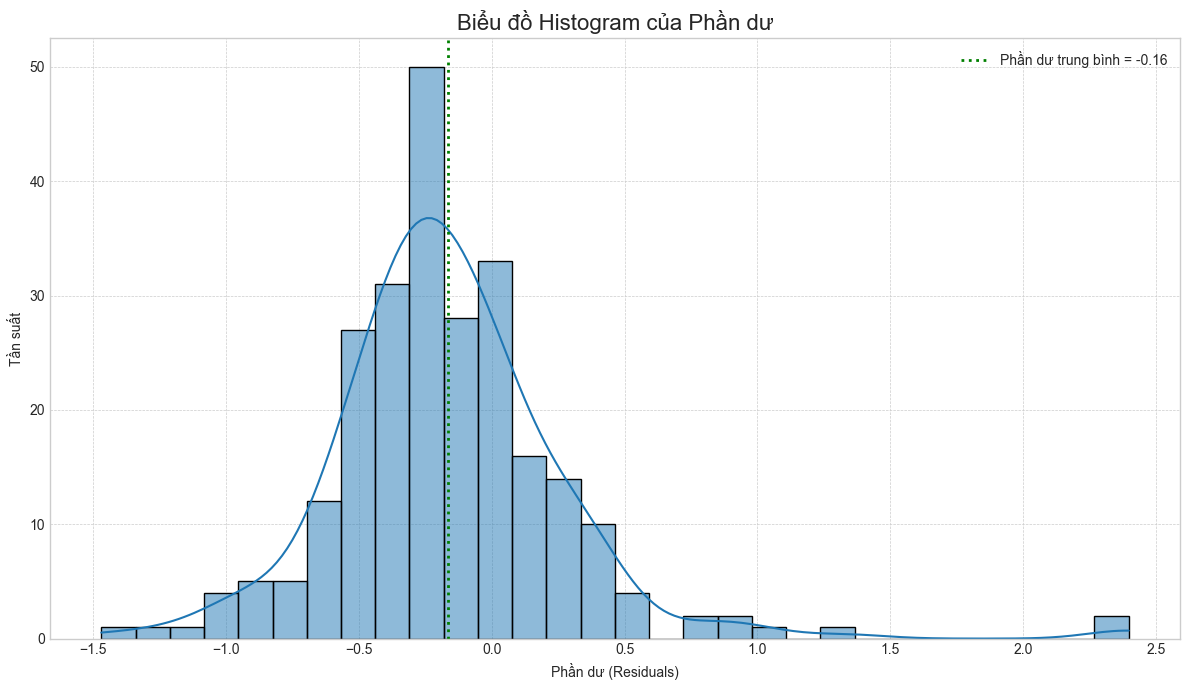

In [123]:
plot_resi(metrics)

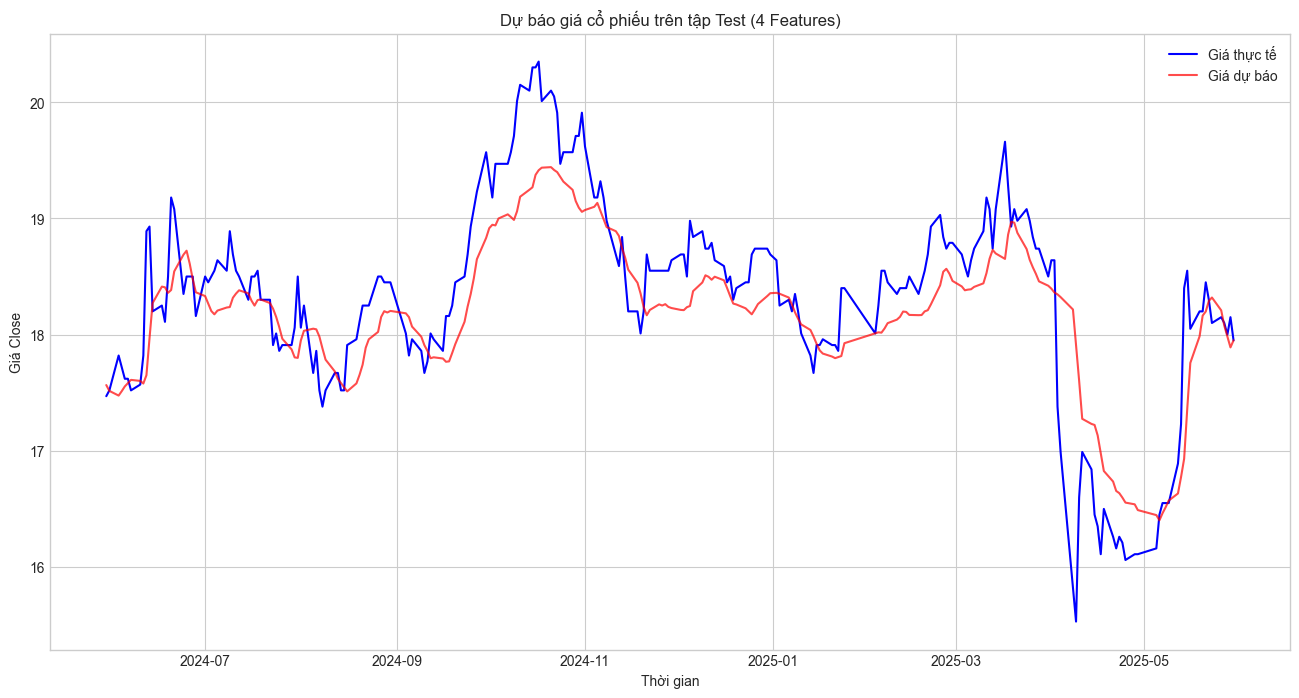

In [124]:
# 6.5. Vẽ biểu đồ so sánh kết quả
plt.figure(figsize=(16, 8))
plt.title('Dự báo giá cổ phiếu trên tập Test (4 Features)')
plt.xlabel('Thời gian')
plt.ylabel('Giá Close')
plt.plot(df['time'].iloc[val_split_index:],  actual_data, color='blue', label='Giá thực tế')
plt.plot(df['time'].iloc[val_split_index:], forecast, color='red', alpha=0.7, label='Giá dự báo')
plt.legend()
plt.grid(True)
plt.show()

## ARIMA - ANN

In [45]:
from pmdarima import auto_arima
import pmdarima as pm
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor

In [51]:
split_point = int(len(df) * 0.85)
train_data = df['close'].iloc[:split_point]
test_data = df['close'].iloc[split_point:]

warnings.filterwarnings('ignore')

N_LAGS = 5
# SIÊU THAM SỐ MỚI: Kích thước của cửa sổ để đánh giá hiệu suất
WINDOW_SIZE = 5

def create_ann_dataset(data, n_lags):
    X, y = [], []
    for i in range(len(data) - n_lags):
        X.append(data[i:(i + n_lags)])
        y.append(data[i + n_lags])
    return np.array(X), np.array(y)

# Huấn luyện ANN một lần duy nhất trên tập train
X_train_ann, y_train_ann = create_ann_dataset(train_data.values, N_LAGS)
ann_model = MLPRegressor(hidden_layer_sizes=(10, 5), max_iter=1000, random_state=42, activation='relu')
ann_model.fit(X_train_ann, y_train_ann)

# Tính toán các sai số của ANN trên tập train để làm mồi
ann_preds_insample = ann_model.predict(X_train_ann)
ann_train_errors = list(y_train_ann - ann_preds_insample)

# --- Bước 2: "Cold Start" - Tính toán trọng số ban đầu dựa trên tập TRAIN ---
print("--- Tính toán trọng số ban đầu trên tập train ---")
arima_model_initial = pm.auto_arima(train_data, seasonal=False, suppress_warnings=True, stepwise=True)
arima_preds_on_train = arima_model_initial.predict_in_sample()
ann_preds_on_train = ann_model.predict(X_train_ann)

arima_mape_initial = mean_absolute_percentage_error(train_data.iloc[-5:], arima_preds_on_train[-5:])    # sửa ở đây
ann_mape_initial = mean_absolute_percentage_error(y_train_ann[-5:], ann_preds_on_train[-5:])            # sửa ở đây
print('arime mape lần 0:', arima_mape_initial)
print('ann mape lần 0', ann_mape_initial)

total_mape_initial = ann_mape_initial + arima_mape_initial + 1e-9
ann_weight = arima_mape_initial / total_mape_initial
arima_weight = 1 - ann_weight
print(f"Trọng số ban đầu: ANN={ann_weight:.2f}, ARIMA={arima_weight:.2f}")

# --- Bước 3: Vòng lặp Dự báo với Trọng số Động dựa trên CỬA SỔ TRƯỢT ---
print(f"\n--- Bắt đầu dự báo với trọng số động trên cửa sổ {WINDOW_SIZE} điểm gần nhất ---")
history = list(train_data)
hybrid_predictions = []

for t in range(len(test_data)):
    current_year = test_data.index[t]
    
    # 3.1: Dự báo 1 bước cho thời điểm t (SỬ DỤNG TRỌNG SỐ TỪ BƯỚC TRƯỚC)
    arima_model_step = pm.auto_arima(pd.Series(history), seasonal=False, suppress_warnings=True, stepwise=True)
    # ----- DÒNG ĐÃ SỬA LỖI -----
    # Sử dụng .iloc[0] để lấy giá trị đầu tiên bất kể index là gì
    arima_pred = arima_model_step.predict(n_periods=1).iloc[0] 
    # ---------------------------

    input_ann = np.array(history[-N_LAGS:]).reshape(1, -1)
    ann_pred = ann_model.predict(input_ann)[0]
    
    # 3.2: Tính dự báo hybrid có trọng số
    weighted_pred = arima_weight * arima_pred + ann_weight * ann_pred

    # 3.3: Tính thành phần hiệu chỉnh sai số
    if len(ann_train_errors) >= 3:
        error_correction = np.mean(ann_train_errors[-3:])
    else:
        error_correction = np.mean(ann_train_errors) if ann_train_errors else 0

    # 3.4: Tính dự báo cuối cùng
    final_pred = weighted_pred - error_correction
    hybrid_predictions.append(final_pred)

    # 3.5: Cập nhật lịch sử và sai số
    actual_value = test_data.iloc[t]
    history.append(actual_value)
    new_ann_error = actual_value - ann_pred
    ann_train_errors.append(new_ann_error)

    # 3.6: CẬP NHẬT TRỌNG SỐ CHO BƯỚC TIẾP THEO (t+1) DỰA TRÊN CỬA SỔ
    arima_preds_in_history = arima_model_step.predict_in_sample()
    X_hist_ann, y_hist_ann = create_ann_dataset(np.array(history), N_LAGS)
    ann_preds_in_history = ann_model.predict(X_hist_ann)
    
    true_window = y_hist_ann[-WINDOW_SIZE:]
    ann_pred_window = ann_preds_in_history[-WINDOW_SIZE:]
    arima_pred_window = arima_preds_in_history[len(arima_preds_in_history) - len(true_window):][-WINDOW_SIZE:]

    arima_mape_new = mean_absolute_percentage_error(true_window, arima_pred_window)
    ann_mape_new = mean_absolute_percentage_error(true_window, ann_pred_window)

    total_mape_new = ann_mape_new + arima_mape_new + 1e-9
    ann_weight = arima_mape_new / total_mape_new
    arima_weight = 1 - ann_weight
    
    print(f"Năm {current_year}: Dự báo={final_pred:.2f}, Thực tế={actual_value:.2f} -> Trọng số ANN cho năm sau={ann_weight:.2f}")

--- Tính toán trọng số ban đầu trên tập train ---
arime mape lần 0: 0.004639568761172503
ann mape lần 0 0.007344499762600161
Trọng số ban đầu: ANN=0.39, ARIMA=0.61

--- Bắt đầu dự báo với trọng số động trên cửa sổ 5 điểm gần nhất ---
Năm 2024-08-26 00:00:00: Dự báo=18.26, Thực tế=18.50 -> Trọng số ANN cho năm sau=0.63
Năm 2024-08-27 00:00:00: Dự báo=18.33, Thực tế=18.50 -> Trọng số ANN cho năm sau=0.67
Năm 2024-08-28 00:00:00: Dự báo=18.38, Thực tế=18.45 -> Trọng số ANN cho năm sau=0.61
Năm 2024-08-29 00:00:00: Dự báo=18.41, Thực tế=18.45 -> Trọng số ANN cho năm sau=0.52
Năm 2024-08-30 00:00:00: Dự báo=18.43, Thực tế=18.45 -> Trọng số ANN cho năm sau=0.55
Năm 2024-09-04 00:00:00: Dự báo=18.44, Thực tế=18.01 -> Trọng số ANN cho năm sau=0.55
Năm 2024-09-05 00:00:00: Dự báo=18.28, Thực tế=17.82 -> Trọng số ANN cho năm sau=0.56
Năm 2024-09-06 00:00:00: Dự báo=18.15, Thực tế=17.96 -> Trọng số ANN cho năm sau=0.55
Năm 2024-09-09 00:00:00: Dự báo=18.06, Thực tế=17.86 -> Trọng số ANN cho năm s

KeyboardInterrupt: 